# PROJETO FINAL
INTRODUÇÂO AO PROCESSAMENTO DE IMAGENS


Prof. Bruno Luiggi Macchiavello Espinoza


- Lucas Corrêa Boaventura - 211038262

- Gustavo - 

## Bibliotecas

In [991]:
import numpy as np
from PIL import Image
from IPython.display import display
import cv2
import matplotlib.pyplot as plt

In [992]:
class my_DataSet():
    def __init__(self, *paths) -> None:
        self.__dataset = np.array([np.array(Image.open(path).resize((240, 240))) for path in paths])
    
    def get(self, *i) -> np.array:
        return self.__dataset[i]
    
    def get_gray(self,*i) -> np.array:
        return np.array([cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY) for arr in self.__dataset])[i]
    
    def show(self,*i) -> None:
        for arr in self.__dataset[i]:
            display(Image.fromarray(arr))

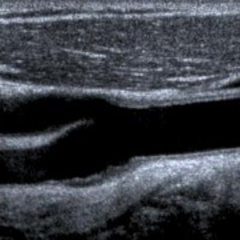

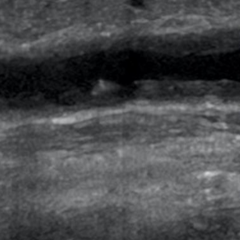

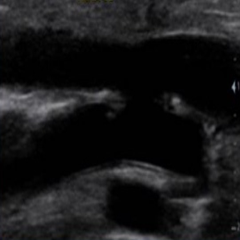

In [993]:
dataset = my_DataSet("tatiana.png","arteria_simples.jpg","arteria_dupla.jpg")
dataset.show()

RGB


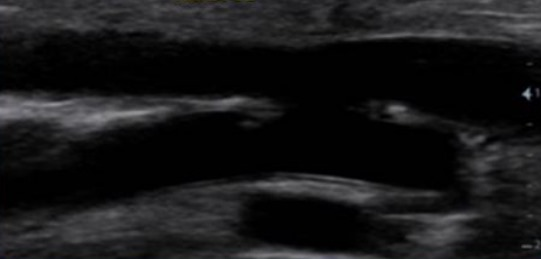

In [994]:
img = Image.open("arteria_dupla.jpg")
print(img.mode)
array_orig = np.array(img)
display(img)
gray_img = cv2.cvtColor(array_orig, cv2.COLOR_RGB2GRAY)

## Thresholding

### Global

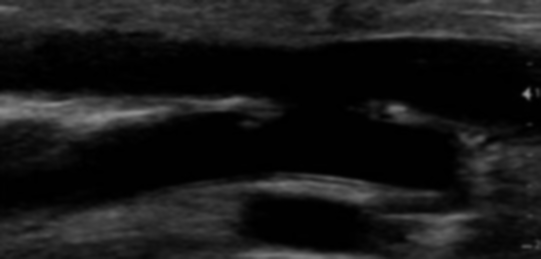

In [995]:
img_low_filter = cv2.GaussianBlur(gray_img, (5, 5), 0)
Image.fromarray(img_low_filter)

In [996]:
# histograma = cv2.calcHist([img_low_filter], [0], None, [256], [0, 256])
# plt.figure(figsize=(5, 3))
# plt.plot(histograma, color='black')
# plt.title('Imagem original')
# plt.xlabel('Intensidade de Cinza')
# plt.ylabel('Número de Pixels')
# plt.grid()
# plt.show()

(259, 541)
Método OTSU


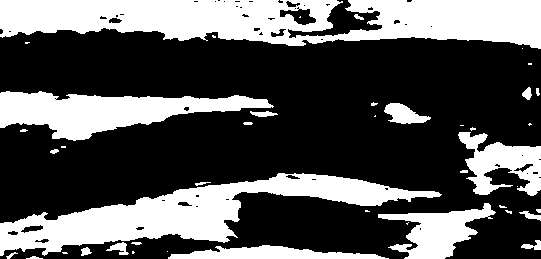

In [997]:
_, img_bin = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# _, img_bin_dps_filtro = cv2.threshold(img_low_filter, 0, 255, cv2.THRESH_BINARY+ cv2.THRESH_OTSU)

print(img_bin.shape)
print("Método OTSU")
display(Image.fromarray(img_bin))
# print("Método OTSU após um filtro Gaussiano")
# Image.fromarray(img_bin_dps_filtro)

### Local

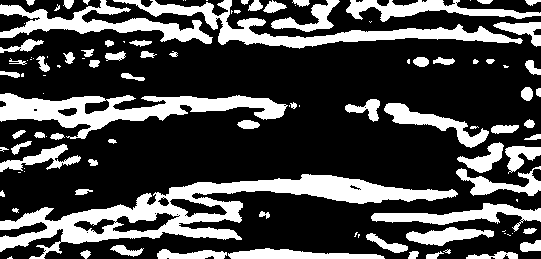

In [998]:
blurred = cv2.GaussianBlur(gray_img, (15, 15), 0)

thresh_mean = cv2.adaptiveThreshold(
    blurred, 
    255, 
    cv2.ADAPTIVE_THRESH_MEAN_C, 
    cv2.THRESH_BINARY , 
    19,  # Tamanho do bloco (área local)
    0    # Constante subtraída da média
)

# Aplicar Threshold Adaptativo - Método Gaussiano
thresh_gaussian = cv2.adaptiveThreshold(
    blurred, 
    255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY, 
    19,  # Tamanho do bloco (área local)
    0    # Constante subtraída da média ponderada
)

Image.fromarray(thresh_mean)


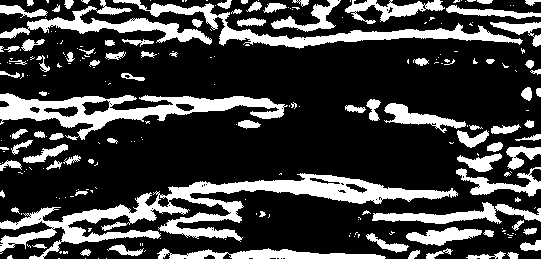

In [999]:
Image.fromarray(thresh_gaussian)

## Watershed

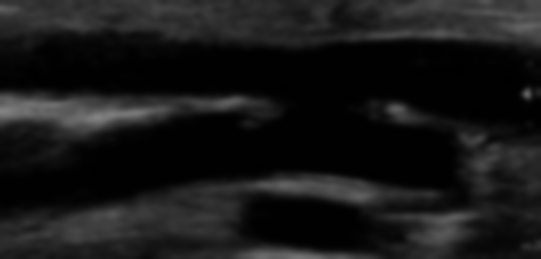

In [1000]:
img_low_filter = cv2.GaussianBlur(gray_img, (15, 15), 0)
Image.fromarray(img_low_filter)

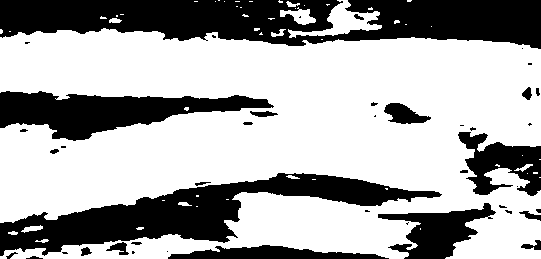

In [1001]:
ret, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
Image.fromarray(thresh)

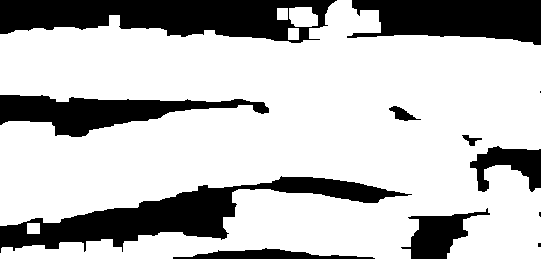

In [1002]:
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# 5. Identificar a área de fundo seguro (dilatação)
sure_bg = cv2.dilate(opening, kernel, iterations=3)
Image.fromarray(sure_bg)

In [1003]:
ret, markers = cv2.connectedComponents(gray_img)
markers

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

In [1004]:
# image=gray_img.copy()

# markers = cv2.watershed(image, markers)
# image[markers == -1] = [255, 0, 0]

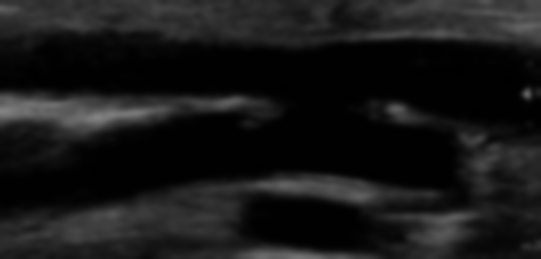

In [1005]:
blurred = cv2.GaussianBlur(gray_img, (15, 15), 0)
# Apply thresholding
Image.fromarray(blurred)


In [1006]:
ret, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Remove noise
# kernel = np.ones((5, 5), np.uint8)
# opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)


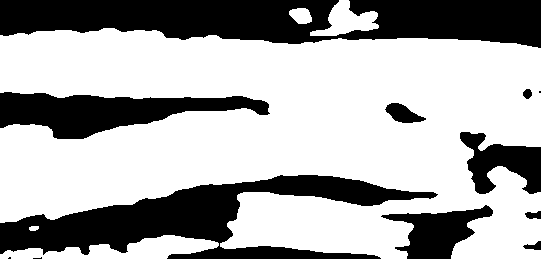

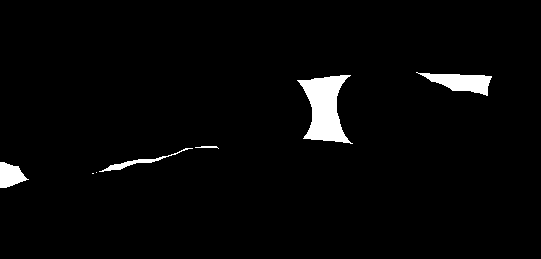

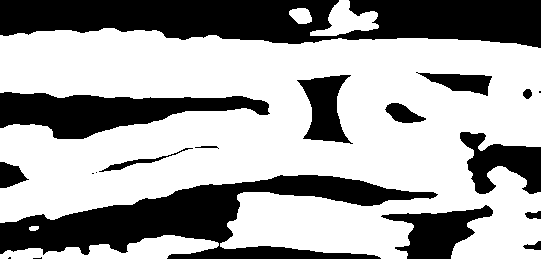

In [1007]:
# Fundo
sure_bg = cv2.dilate(thresh, kernel, iterations=1)
display(Image.fromarray(sure_bg))

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 0)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
display(Image.fromarray(sure_fg))


unknown = cv2.subtract(sure_bg, sure_fg)
Image.fromarray(unknown)

In [1008]:
_, markers = cv2.connectedComponents(sure_fg)

markers = markers + 1
markers[unknown == 255] = 0
markers = cv2.watershed(array_orig, markers)


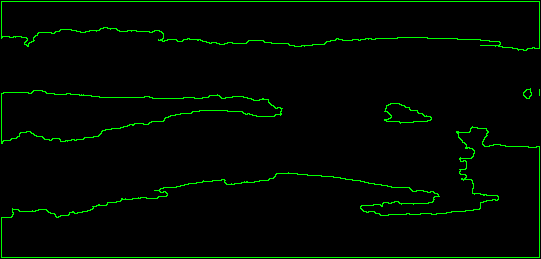

In [1009]:
water_fill = np.zeros(np.array(img).shape, dtype=np.uint8)
water_fill[markers == 1] = [0,255,0] #selecionado manualmente a label que preencheu a area requerida

kernel = np.ones((3, 3), np.uint8)
erosion = cv2.erode(water_fill, np.ones((3, 3), np.uint8))
contour = water_fill-erosion
Image.fromarray(contour)


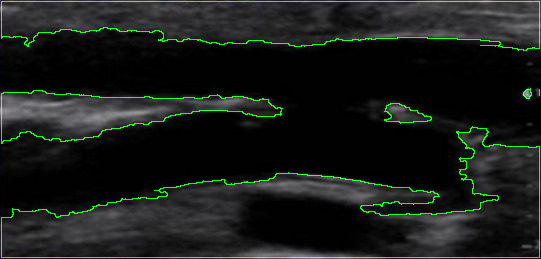

In [1010]:
tumor_highlighted = cv2.addWeighted(array_orig, 1, contour,1, 0)
Image.fromarray(tumor_highlighted)